
# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
import pickle

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import LabelEncoder

# Loading data
Data consists of all PL players logs for 2021-22 and 2022-23 seasons\
A single log is just a summary of player performance in a particular match

In [3]:
# loading csv
df_original = pd.read_csv('data/previous/FPL_logs.csv')

df = df_original.copy()

In [4]:
df_original.columns

Index(['Date', 'Day', 'Venue', 'Team', 'Opponent', 'Name', 'Start', 'Pos',
       'Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh', 'SoT', 'CrdY', 'CrdR',
       'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG', 'xA', 'SCA', 'GCA',
       'Cmp', 'Att', 'Cmp%', 'PrgP', 'Carries', 'PrgC', 'T_att', 'T_succ',
       'Season', 'WDL', 'Team_score', 'Opp_score', 'Team_CS', 'Was_home', 'GW',
       'Clean_name', 'FPL_name', 'FPL_team', 'FPL_opp_team', 'Name_original',
       'FPL_pos', 'FPL_ast', 'Bonus', 'Bps', 'Player_CS', 'Creativity',
       'Element', 'Fixture', 'Player_GC', 'Goals_scored', 'ICT_index',
       'Influence', 'Kickoff_time', 'FPL_min', 'Own_goals', 'Penalties_missed',
       'Penalties_saved', 'Saves', 'Selected', 'Threat', 'FPL_points',
       'Transfers_balance', 'Transfers_in', 'Transfers_out', 'Value', 'FPL_GW',
       'xP', 'FPL_xA', 'FPL_xGI', 'FPL_xG', 'FPL_xGC', 'Opp_rating',
       'Team_rating', 'Min_points'],
      dtype='object')

In [5]:
df_original["Name"].unique().size

484

In [6]:
df.shape

(19421, 80)

In [7]:
df["Season"].unique()

array(['2021-22', '2022-23', '2023-24'], dtype=object)

In [8]:
# df = df[~df["FPL_pos"].isin(["GK"])]

In [9]:
df = df.sort_values(by=["Name", "Date"])

# Feature selection
Model will use a set of standard features and moving averages for some other feature values. In this case we will use moving averages for last 2, 4 and 30 gameweeks.

In [10]:
rolling_gameweeks = [2, 4, 30]
# rolling_gameweeks = [5]

to_predict = ["FPL_points"]
standard_features = [
             "Was_home", # Home/Away
             "Team_rating", "Opp_rating", "Rating_difference" # Team ratings
             ]
features_to_roll = [
                "Min", "Start", # time played
                'Gls', 'Sh', 'SoT', # Goals
                'Ast', # Assists
                'CrdY', 'CrdR', # Cards
                "xG", 'xA', # Expected
                'Team_CS', # Defence
                'Team_score', 'Opp_score', 'Team_result', # Team form
                # "xGPoints", "CSPoints", # Position-scaled
                # "Cmp%", "PrgP", "PrgC", "T_succ",
                # 'bonus', 'bps', # Bonus
                # 'Influence', 'Creativity', 'Threat', 
                'ICT_index', # ICT
                "FPL_points", "Baseline_points", "Bonus" # FPL points
            ]
info = ["Name_original", "GW", "Season", "Team", "Opponent", "Was_home", "Team_rating", "Opp_rating", "FPL_pos"]

In [11]:
# df[df["Name"] == "Erling-Haaland"]

# Feature engineering

In [12]:
df["Rating_difference"] = df["Team_rating"] / df["Opp_rating"]
df["Baseline_points"] = df["FPL_points"] - df["Bonus"]

In [13]:
def calculate_team_points(row):
    # win - 3 points
    if row['Team_score'] > row['Opp_score']:
        return 3
    # draw - 1 point
    elif row['Team_score'] == row['Opp_score']:
        return 1
    # loss - 0 points
    else:
        return 0
    
df['Team_result'] = df.apply(calculate_team_points, axis=1)

In [14]:
def add_rolling_features(df, standard_features, features_to_roll):
    features = standard_features
    
    for r in rolling_gameweeks:
        form_means = df.groupby(["Name"])[features_to_roll].rolling(r, min_periods=1).mean().groupby(["Name"]).shift(1).reset_index()
        # print(form_means[form_means["Name"] == "Erling-Haaland"])
        form_means = form_means.fillna(method='bfill') # slightly incorrect, better to drop Nan
        form_means.columns = [f'{col}{"_"}{r}' for col in form_means.columns]
        features += form_means.columns.tolist()
        features = list(filter(lambda x: x not in ["Name_" + str(r)], features))
        df = pd.concat([df.reset_index(), form_means], axis=1)
        # df = df.merge(form_means, left_index=True, right_index=True)
        df = df.drop([col for col in df.columns if col.startswith('level')], axis=1)
        
    return df.reset_index(), features

In [15]:
def ohe(df, ohe_columns, features):
    # one hot encoding
    for c in ohe_columns:
        ohe_c = pd.get_dummies(df[c], dtype="int64")
        df = pd.concat([df, ohe_c], axis=1)

        features += ohe_c.columns.tolist()
        
    return df, features

In [16]:
def label_encoding(df, column_to_encode):
    
    mapping_dict = {
        'Y': 1, # Starting eleven
        'Y*': 1, # Starting eleven as captain
        'N': 0, # Not in starting eleven
    }
    
    df[column_to_encode] = df[column_to_encode].map(mapping_dict)
    
    return df

In [17]:
df = label_encoding(df, "Start")

In [18]:
df, features = add_rolling_features(df, standard_features, features_to_roll)

In [19]:
df, features = ohe(df, ["FPL_pos"], features)
df = df.drop("GK", axis=1)
features.remove("GK")

In [20]:
# dropping unwanted columns
features = [col for col in features if not col.startswith('level')]
df = df[np.unique(features + info + to_predict)]

In [21]:
df = df[pd.to_numeric(df["GW"], errors="coerce").notna()]
df["GW"] = df["GW"].astype("uint64")

In [22]:
# dropping NaNs
df = df.dropna(axis=0)

In [23]:
# df = df.set_index(["Name_original", "Season", "GW"], drop=False)

In [24]:
df.columns

Index(['Ast_2', 'Ast_30', 'Ast_4', 'Baseline_points_2', 'Baseline_points_30',
       'Baseline_points_4', 'Bonus_2', 'Bonus_30', 'Bonus_4', 'CrdR_2',
       'CrdR_30', 'CrdR_4', 'CrdY_2', 'CrdY_30', 'CrdY_4', 'DEF', 'FPL_points',
       'FPL_points_2', 'FPL_points_30', 'FPL_points_4', 'FPL_pos', 'FWD', 'GW',
       'Gls_2', 'Gls_30', 'Gls_4', 'ICT_index_2', 'ICT_index_30',
       'ICT_index_4', 'MID', 'Min_2', 'Min_30', 'Min_4', 'Name_original',
       'Opp_rating', 'Opp_score_2', 'Opp_score_30', 'Opp_score_4', 'Opponent',
       'Rating_difference', 'Season', 'Sh_2', 'Sh_30', 'Sh_4', 'SoT_2',
       'SoT_30', 'SoT_4', 'Start_2', 'Start_30', 'Start_4', 'Team',
       'Team_CS_2', 'Team_CS_30', 'Team_CS_4', 'Team_rating', 'Team_result_2',
       'Team_result_30', 'Team_result_4', 'Team_score_2', 'Team_score_30',
       'Team_score_4', 'Was_home', 'xA_2', 'xA_30', 'xA_4', 'xG_2', 'xG_30',
       'xG_4'],
      dtype='object')

In [25]:
df.shape

(17485, 68)

In [26]:
# saving to file
df.set_index(["Name_original", "Season", "GW"], drop=False).to_csv("data/misc/df_features.csv", index=False) # keeping GKs on

In [27]:
df = df[~df["FPL_pos"].isin(["GK"])] # only outfield players

# Data split into train and valid
Let's take entire 2021-22 season and 30 first gameweeks of 2022-23 season as training data and 8 last gameweeks of that season as valid data (~10% of all rows).

In [28]:
def shrink_df_to_top_players(df, n_players, min_fixtures):
    # Calculate average scores
    average_scores = df.groupby('Name_original')['FPL_points'].mean()
    
    # Calculate player counts
    player_counts = df['Name_original'].value_counts()
    
    # Filter out players with less than min_fixtures occurrences
    popular_players = player_counts[player_counts >= min_fixtures].index
    
    print("Unique players with min_fixtures:", popular_players.size)

    # Sort players by average scores
    sorted_players = average_scores.sort_values(ascending=False)

    # Get the top n_players players
    top_popular_players = sorted_players[sorted_players.index.isin(popular_players)].head(n_players)

    # Filter the original DataFrame
    top_players_df = df[df['Name_original'].isin(top_popular_players.index)]
    
    print("Unique players left:", top_players_df['Name_original'].unique().size)
    
    return top_players_df

In [29]:
CUT_OFF_GAMEWEEK = 31
SEASON_TO_PREDICT = "2022-23"

In [30]:
df_train = shrink_df_to_top_players(df, 550, 10)
# df_train["Name_original"].unique()

Unique players with min_fixtures: 354
Unique players left: 354


In [31]:
df = df.set_index(["Name_original", "Season", "GW"], drop=False)

In [32]:
# training data
X_train = df_train[((df_train["Season"] < SEASON_TO_PREDICT) | (df_train["GW"] <= CUT_OFF_GAMEWEEK - 1))][features].reset_index(drop=True)
y_train = df_train[((df_train["Season"] < SEASON_TO_PREDICT) | (df_train["GW"] <= CUT_OFF_GAMEWEEK - 1))][to_predict].reset_index(drop=True)

In [33]:
# only 31st gameweek
X_test = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][features].reset_index(drop=True)
y_test = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][to_predict].reset_index(drop=True)

In [34]:
# all remaining gameweeks
X_test_all_remaining = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][features].reset_index(drop=True)
y_test_all_remaining = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][to_predict].reset_index(drop=True)

In [35]:
X_train.shape, X_test.shape, X_test_all_remaining.shape

((13642, 61), (232, 61), (1971, 61))

# Model

In [36]:
# model = GradientBoostingRegressor(random_state=42)
model = XGBRegressor(
        random_state=42,
        n_estimators=500,
        early_stopping_rounds=5,
        learning_rate=0.2
    )
# model = RandomForestRegressor(random_state=42)

In [37]:
%%time
model.fit(
        X_train, 
        np.array(y_train).ravel(),
        eval_set=[(X_test_all_remaining, y_test_all_remaining)],
        verbose=False
    )

CPU times: total: 2.11 s
Wall time: 319 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

# Getting predictions

In [38]:
def get_predictions(model, df, X, all_remaining=False):
    # make predictions on the test data and glues them to the rest of the dataframe
    predictions = model.predict(X)
    
    if all_remaining:
        df_predictions = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT)].reset_index(drop=True)
    else:
        df_predictions = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT)].reset_index(drop=True)
        
    df_predictions.loc[:, "Pred"] = predictions
    
    preds = df_predictions[info + to_predict + ["Pred"]].sort_values(by=["Pred"], ascending = False)
    
    return preds, predictions

In [39]:
preds, predictions = get_predictions(model, df, X_test)

In [40]:
preds_all_gameweeks, predictions_all = get_predictions(model, df, X_test_all_remaining, True)

In [41]:
df.columns

Index(['Ast_2', 'Ast_30', 'Ast_4', 'Baseline_points_2', 'Baseline_points_30',
       'Baseline_points_4', 'Bonus_2', 'Bonus_30', 'Bonus_4', 'CrdR_2',
       'CrdR_30', 'CrdR_4', 'CrdY_2', 'CrdY_30', 'CrdY_4', 'DEF', 'FPL_points',
       'FPL_points_2', 'FPL_points_30', 'FPL_points_4', 'FPL_pos', 'FWD', 'GW',
       'Gls_2', 'Gls_30', 'Gls_4', 'ICT_index_2', 'ICT_index_30',
       'ICT_index_4', 'MID', 'Min_2', 'Min_30', 'Min_4', 'Name_original',
       'Opp_rating', 'Opp_score_2', 'Opp_score_30', 'Opp_score_4', 'Opponent',
       'Rating_difference', 'Season', 'Sh_2', 'Sh_30', 'Sh_4', 'SoT_2',
       'SoT_30', 'SoT_4', 'Start_2', 'Start_30', 'Start_4', 'Team',
       'Team_CS_2', 'Team_CS_30', 'Team_CS_4', 'Team_rating', 'Team_result_2',
       'Team_result_30', 'Team_result_4', 'Team_score_2', 'Team_score_30',
       'Team_score_4', 'Was_home', 'xA_2', 'xA_30', 'xA_4', 'xG_2', 'xG_30',
       'xG_4'],
      dtype='object')

# Custom metric
Such models are usually used to compare players and decide who to pick for upcoming gameweek(s). For each player pair in a subset of players model can either predict the outcome well (e.g. player A scores more than player B and model predicts exactly that) or predict wrongly (e.g. player A scores more than player B but model predicts player B > player A). Pairwise_accuracy returns the percentage of corrected predicted pairs. Pairwise_accuracy_topX is a variation of this metric calculated only for X highest scoring players of last two seasons.

In [42]:
def get_top_performer_names(df, no_top, no_gws):
    # takes no_top players that recorded highest average FPL points in no_gws last gameweeks
    return df.reset_index(drop=True).groupby("Name_original")["FPL_points"].mean().groupby("Name_original").tail(no_gws).sort_values(ascending=False).head(no_top).index.to_list()

In [43]:
def pairwise_accuracy(predicted_scores, true_scores):
    if len(predicted_scores) != len(true_scores):
        raise ValueError("The length of predicted_scores and true_scores must be the same.")

    num_pairs = 0
    num_correct_pairs = 0

    for i in range(len(predicted_scores)):
        for j in range(i + 1, len(predicted_scores)):
            # Check if the predicted order matches the true order
            if (predicted_scores[i] > predicted_scores[j] and true_scores[i] > true_scores[j]) or \
               (predicted_scores[i] < predicted_scores[j] and true_scores[i] < true_scores[j]):
                num_correct_pairs += 1
            num_pairs += 1

    pairwise_accuracy = num_correct_pairs / num_pairs
    return pairwise_accuracy

In [44]:
def pairwise_accuracy_topX(model, df, top_x, all_gw=False):
    # pairwise_accuracy for top_X players
    if all_gw:
        top_performers = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name_original"].isin(get_top_performer_names(df, top_x, 50)))]
    else:
        top_performers = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name_original"].isin(get_top_performer_names(df, top_x, 50)))]

    X = top_performers[features].reset_index(drop=True)
    y = np.array(top_performers[to_predict].reset_index(drop=True))
    preds = model.predict(X)
    
    return  pairwise_accuracy(preds, y)

# Evaluation

In [45]:
def evaluate(model, df, predictions, y_true, all_gw=False):
    # function to calculate different metrics for a given model
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)

    pairwise_acc = pairwise_accuracy(np.array(y_true), predictions)
    pairwise_accuracy_top20 = pairwise_accuracy_topX(model, df, 20, all_gw)
    pairwise_accuracy_top100 = pairwise_accuracy_topX(model, df, 100, all_gw)
    
    print("MAE:", mae)
    print("MSE:", mse)
    print("Pairwise accuracy:", pairwise_acc)
    print("Pairwise accuracy @TOP100:", pairwise_accuracy_top100)
    print("Pairwise accuracy @TOP20:", pairwise_accuracy_top20)
    print("Avg pred vs avg true:", np.mean(predictions).round(2), "vs", np.mean(y_true).round(2).item())

In [46]:
# df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name"].isin(get_top_performer_names(df, 20, 50)))].columns

In [47]:
# next gameweek
evaluate(model, df, predictions, y_test, all_gw=False)

MAE: 1.8489794999617954
MSE: 7.992505013800627
Pairwise accuracy: 0.5508658008658008
Pairwise accuracy @TOP100: 0.47151983360570493
Pairwise accuracy @TOP20: 0.46302124311565696
Avg pred vs avg true: 2.23 vs 2.38


In [48]:
# all remaining gameweeks
evaluate(model, df, predictions_all, y_test_all_remaining, all_gw=True)

MAE: 1.8552773121738724
MSE: 7.72350527527092
Pairwise accuracy: 0.5532088377926637
Pairwise accuracy @TOP100: 0.43783783783783786
Pairwise accuracy @TOP20: 0.5512820512820513
Avg pred vs avg true: 2.27 vs 2.35


In [49]:
# df[df["Name"] == "Abdoulaye-Doucoure"][info]

In [50]:
# model.predict(df[df["GW"] == GAMEWEEK_TO_PREDICT][df["Name"] == "Mohamed-Salah"][features])

In [51]:
features

['Was_home',
 'Team_rating',
 'Opp_rating',
 'Rating_difference',
 'Min_2',
 'Start_2',
 'Gls_2',
 'Sh_2',
 'SoT_2',
 'Ast_2',
 'CrdY_2',
 'CrdR_2',
 'xG_2',
 'xA_2',
 'Team_CS_2',
 'Team_score_2',
 'Opp_score_2',
 'Team_result_2',
 'ICT_index_2',
 'FPL_points_2',
 'Baseline_points_2',
 'Bonus_2',
 'Min_4',
 'Start_4',
 'Gls_4',
 'Sh_4',
 'SoT_4',
 'Ast_4',
 'CrdY_4',
 'CrdR_4',
 'xG_4',
 'xA_4',
 'Team_CS_4',
 'Team_score_4',
 'Opp_score_4',
 'Team_result_4',
 'ICT_index_4',
 'FPL_points_4',
 'Baseline_points_4',
 'Bonus_4',
 'Min_30',
 'Start_30',
 'Gls_30',
 'Sh_30',
 'SoT_30',
 'Ast_30',
 'CrdY_30',
 'CrdR_30',
 'xG_30',
 'xA_30',
 'Team_CS_30',
 'Team_score_30',
 'Opp_score_30',
 'Team_result_30',
 'ICT_index_30',
 'FPL_points_30',
 'Baseline_points_30',
 'Bonus_30',
 'DEF',
 'FWD',
 'MID']

In [52]:
len(features)

61

In [53]:
df[df["FPL_pos"] == "GKP"]["FPL_pos"]

Series([], Name: FPL_pos, dtype: object)

# Predictions - next gameweek only

In [54]:
preds.head(30)

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,Pred
69,Erling Haaland,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,FWD,2.0,5.603601
92,Jack Grealish,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,MID,0.0,5.282980
137,Leandro Trossard,31,2022-23,Arsenal,West Ham,0.0,1946.847900,1751.608521,MID,1.0,5.201160
178,Ollie Watkins,31,2022-23,Aston Villa,Newcastle Utd,1.0,1801.513550,1876.322510,FWD,16.0,5.148127
209,Son Heung-min,31,2022-23,Tottenham,Bournemouth,1.0,1851.721558,1665.276123,MID,9.0,4.855337
129,Kevin De Bruyne,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,MID,3.0,4.814688
198,Rodrigo Hernandez,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,MID,1.0,4.564625
150,Martin Ødegaard,31,2022-23,Arsenal,West Ham,0.0,1946.847900,1751.608521,MID,10.0,4.542866
151,Gabriel Martinelli Silva,31,2022-23,Arsenal,West Ham,0.0,1946.847900,1751.608521,MID,5.0,4.499095
91,Ivan Toney,31,2022-23,Brentford,Wolves,0.0,1782.324097,1717.951904,FWD,2.0,4.296112


In [55]:
preds[preds["Team"] == "Manchester City"].head(20)

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,Pred
69,Erling Haaland,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,FWD,2.0,5.603601
92,Jack Grealish,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,MID,0.0,5.282980
129,Kevin De Bruyne,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,MID,3.0,4.814688
198,Rodrigo Hernandez,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,MID,1.0,4.564625
119,John Stones,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,DEF,0.0,3.656492
144,Manuel Akanji,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,DEF,2.0,3.633904
24,Bernardo Veiga de Carvalho e Silva,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,MID,1.0,3.565073
171,Nathan Aké,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,DEF,1.0,3.442174
17,Aymeric Laporte,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,DEF,2.0,3.412721
196,Riyad Mahrez,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,MID,10.0,3.354151


# Predictions - all remaining gameweeks

In [56]:
preds_all_gameweeks.head(15)

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,Pred
1086,Kevin De Bruyne,35,2022-23,Manchester City,Leeds United,1.0,2069.102051,1662.209595,MID,13.0,7.923137
596,Erling Haaland,36,2022-23,Manchester City,Everton,0.0,2071.091064,1694.975464,FWD,7.0,7.385335
597,Erling Haaland,37,2022-23,Manchester City,Chelsea,1.0,2087.472656,1794.311890,FWD,1.0,7.075531
595,Erling Haaland,35,2022-23,Manchester City,Leeds United,1.0,2069.102051,1662.209595,FWD,0.0,6.299577
599,Erling Haaland,38,2022-23,Manchester City,Brentford,0.0,2083.640381,1807.119507,FWD,0.0,6.298261
794,Jack Grealish,35,2022-23,Manchester City,Leeds United,1.0,2069.102051,1662.209595,MID,12.0,6.212452
1506,Ollie Watkins,33,2022-23,Aston Villa,Fulham,1.0,1810.011353,1722.499878,FWD,2.0,5.959212
282,Callum Wilson,37,2022-23,Newcastle Utd,Leicester City,1.0,1879.238159,1707.616699,FWD,0.0,5.957645
1399,Mohamed Salah,35,2022-23,Liverpool,Brentford,1.0,1940.118652,1782.052979,MID,10.0,5.876746
787,Ivan Toney,32,2022-23,Brentford,Aston Villa,1.0,1763.556641,1810.020996,FWD,9.0,5.723259


In [57]:
preds_all_gameweeks[preds_all_gameweeks["Name_original"] == "Mohamed Salah"].sort_values(by=["GW"])

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,Pred
1396,Mohamed Salah,32,2022-23,Liverpool,Nott'ham Forest,1.0,1926.870483,1623.869263,MID,7.0,4.778078
1397,Mohamed Salah,33,2022-23,Liverpool,West Ham,0.0,1928.467651,1771.272461,MID,2.0,3.664808
1398,Mohamed Salah,34,2022-23,Liverpool,Tottenham,1.0,1933.697876,1817.128296,MID,7.0,5.641636
1399,Mohamed Salah,35,2022-23,Liverpool,Brentford,1.0,1940.118652,1782.052979,MID,10.0,5.876746
1400,Mohamed Salah,36,2022-23,Liverpool,Leicester City,0.0,1944.225098,1709.140503,MID,14.0,4.057040
1401,Mohamed Salah,37,2022-23,Liverpool,Aston Villa,1.0,1955.095703,1812.286499,MID,5.0,4.553194
1402,Mohamed Salah,38,2022-23,Liverpool,Southampton,0.0,1950.095581,1616.916626,MID,5.0,4.480819


In [58]:
preds_all_gameweeks[preds_all_gameweeks["Name_original"] == "Erling Haaland"].sort_values(by=["GW"])

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,Pred
592,Erling Haaland,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,FWD,2.0,5.603601
598,Erling Haaland,32,2022-23,Manchester City,Brighton,0.0,2089.150391,1826.267822,FWD,5.0,4.841059
593,Erling Haaland,33,2022-23,Manchester City,Arsenal,1.0,2057.953369,1928.582397,FWD,14.0,3.389646
594,Erling Haaland,34,2022-23,Manchester City,Fulham,0.0,2064.563232,1717.714233,FWD,8.0,5.095271
595,Erling Haaland,35,2022-23,Manchester City,Leeds United,1.0,2069.102051,1662.209595,FWD,0.0,6.299577
596,Erling Haaland,36,2022-23,Manchester City,Everton,0.0,2071.091064,1694.975464,FWD,7.0,7.385335
597,Erling Haaland,37,2022-23,Manchester City,Chelsea,1.0,2087.472656,1794.311890,FWD,1.0,7.075531
599,Erling Haaland,38,2022-23,Manchester City,Brentford,0.0,2083.640381,1807.119507,FWD,0.0,6.298261


In [59]:
preds_all_gameweeks[preds_all_gameweeks["Name_original"] == "Harry Kane"].sort_values(by=["GW"])

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,Pred


# Saving to file

In [60]:
preds_all_gameweeks.to_csv("predictions/all_predictions.csv", index=False)

In [61]:
pickle.dump(model, open("models/GBR.pkl", 'wb'))

# Feature importance and influence

In [62]:
explainer = shap.Explainer(model.predict, X_test_all_remaining)
shap_values = explainer(X_test_all_remaining)

Permutation explainer: 1972it [03:16,  9.68it/s]                                                                                                                     


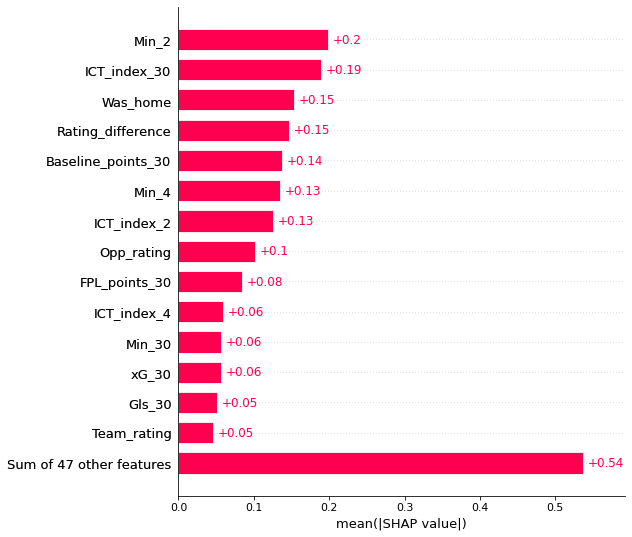

In [63]:
shap.plots.bar(shap_values, max_display=15)

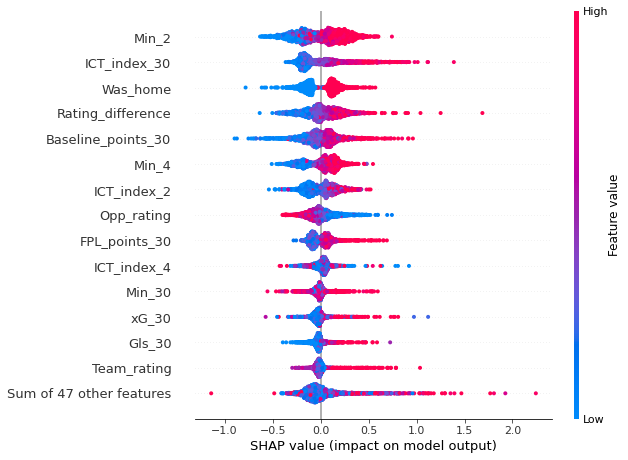

In [64]:
shap.plots.beeswarm(shap_values, max_display=15)

In [65]:
explaining Erling Haaland`s score in gameweek 30
shap.plots.bar(shap_values[123], max_display=15)

SyntaxError: invalid syntax (3945003954.py, line 1)

In [ ]:
shap.plots.waterfall(shap_values[123])